# Store Sales - Time Series Forecasting

In [1]:
# BASE
# ------------------------------------------------------
import numpy as np
import pandas as pd
import os
import gc
import warnings

# PACF - ACF
# ------------------------------------------------------
import statsmodels.api as sm

# DATA VISUALIZATION
# ------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


# CONFIGURATIONS
# ------------------------------------------------------
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings('ignore')

In [2]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.linear_model import LinearRegression
from pandas import date_range
from statsmodels.graphics.tsaplots import plot_pacf

from sklearn.model_selection import train_test_split
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from xgboost import XGBRegressor


from sklearn.linear_model import ElasticNet, Lasso, Ridge

# Model 2
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import RegressorChain
import warnings

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
stores = pd.read_csv("stores.csv") 
transactions = pd.read_csv("transactions.csv").sort_values(["store_nbr", "date"])

In [4]:
# Datetime
train["date"] = pd.to_datetime(train.date)
test["date"] = pd.to_datetime(test.date)
transactions["date"] = pd.to_datetime(transactions.date)

# Data types
train.onpromotion = train.onpromotion.astype("float16")
train.sales = train.sales.astype("float32")
stores.cluster = stores.cluster.astype("int8")

train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.00,0.00
1,1,2013-01-01,1,BABY CARE,0.00,0.00
2,2,2013-01-01,1,BEAUTY,0.00,0.00
3,3,2013-01-01,1,BEVERAGES,0.00,0.00
4,4,2013-01-01,1,BOOKS,0.00,0.00


In [7]:
def plot_deterministic_process(df, key, freq, col, ax1, title1, ax2, title2):
    df_grouped = grouped(df, key, freq, col)
    df_grouped['date'] = pd.to_datetime(df_grouped['date'], format = "%Y-%m-%d") 
    dp = DeterministicProcess(index=df_grouped['date'], constant=True, order=1, drop=True)
    dp.index.freq = freq # manually set the frequency of the index
    # 'in_sample' creates features for the dates given in the `index` argument
    X1 = dp.in_sample()
    y1 = df_grouped["mean"]  # the target
    y1.index = X1.index
    # The intercept is the same as the `const` feature from
    # DeterministicProcess. LinearRegression behaves badly with duplicated
    # features, so we need to be sure to exclude it here.
    model = LinearRegression(fit_intercept=False)
    model.fit(X1, y1)
    y1_pred = pd.Series(model.predict(X1), index=X1.index)
    ax1 = y1.plot(linestyle='dashed', label="mean", color="0.75", ax=ax1, use_index=True)
    ax1 = y1_pred.plot(linewidth=3, label="Trend", color='b', ax=ax1, use_index=True)
    ax1.set_title(title1, fontsize=18)  
    _ = ax1.legend()
    
    # forecast Trend for future 30 steps
    steps = 30 
    X2 = dp.out_of_sample(steps=steps)
    y2_fore = pd.Series(model.predict(X2), index=X2.index)
    y2_fore.head()
    ax2 = y1.plot(linestyle='dashed', label="mean", color="0.75", ax=ax2, use_index=True)
    ax2 = y1_pred.plot(linewidth=3, label="Trend", color='b', ax=ax2, use_index=True)
    ax2 = y2_fore.plot(linewidth=3, label="Predicted Trend", color='r', ax=ax2, use_index=True)
    ax2.set_title(title2, fontsize=18)  
    _ = ax2.legend()

In [11]:
def grouped(df, key, freq, col):
    """ GROUP DATA WITH CERTAIN FREQUENCY """
    df_grouped = df.groupby([pd.Grouper(key=key, freq=freq)]).agg(mean = (col, 'mean'))
    df_grouped = df_grouped.reset_index()
    return df_grouped

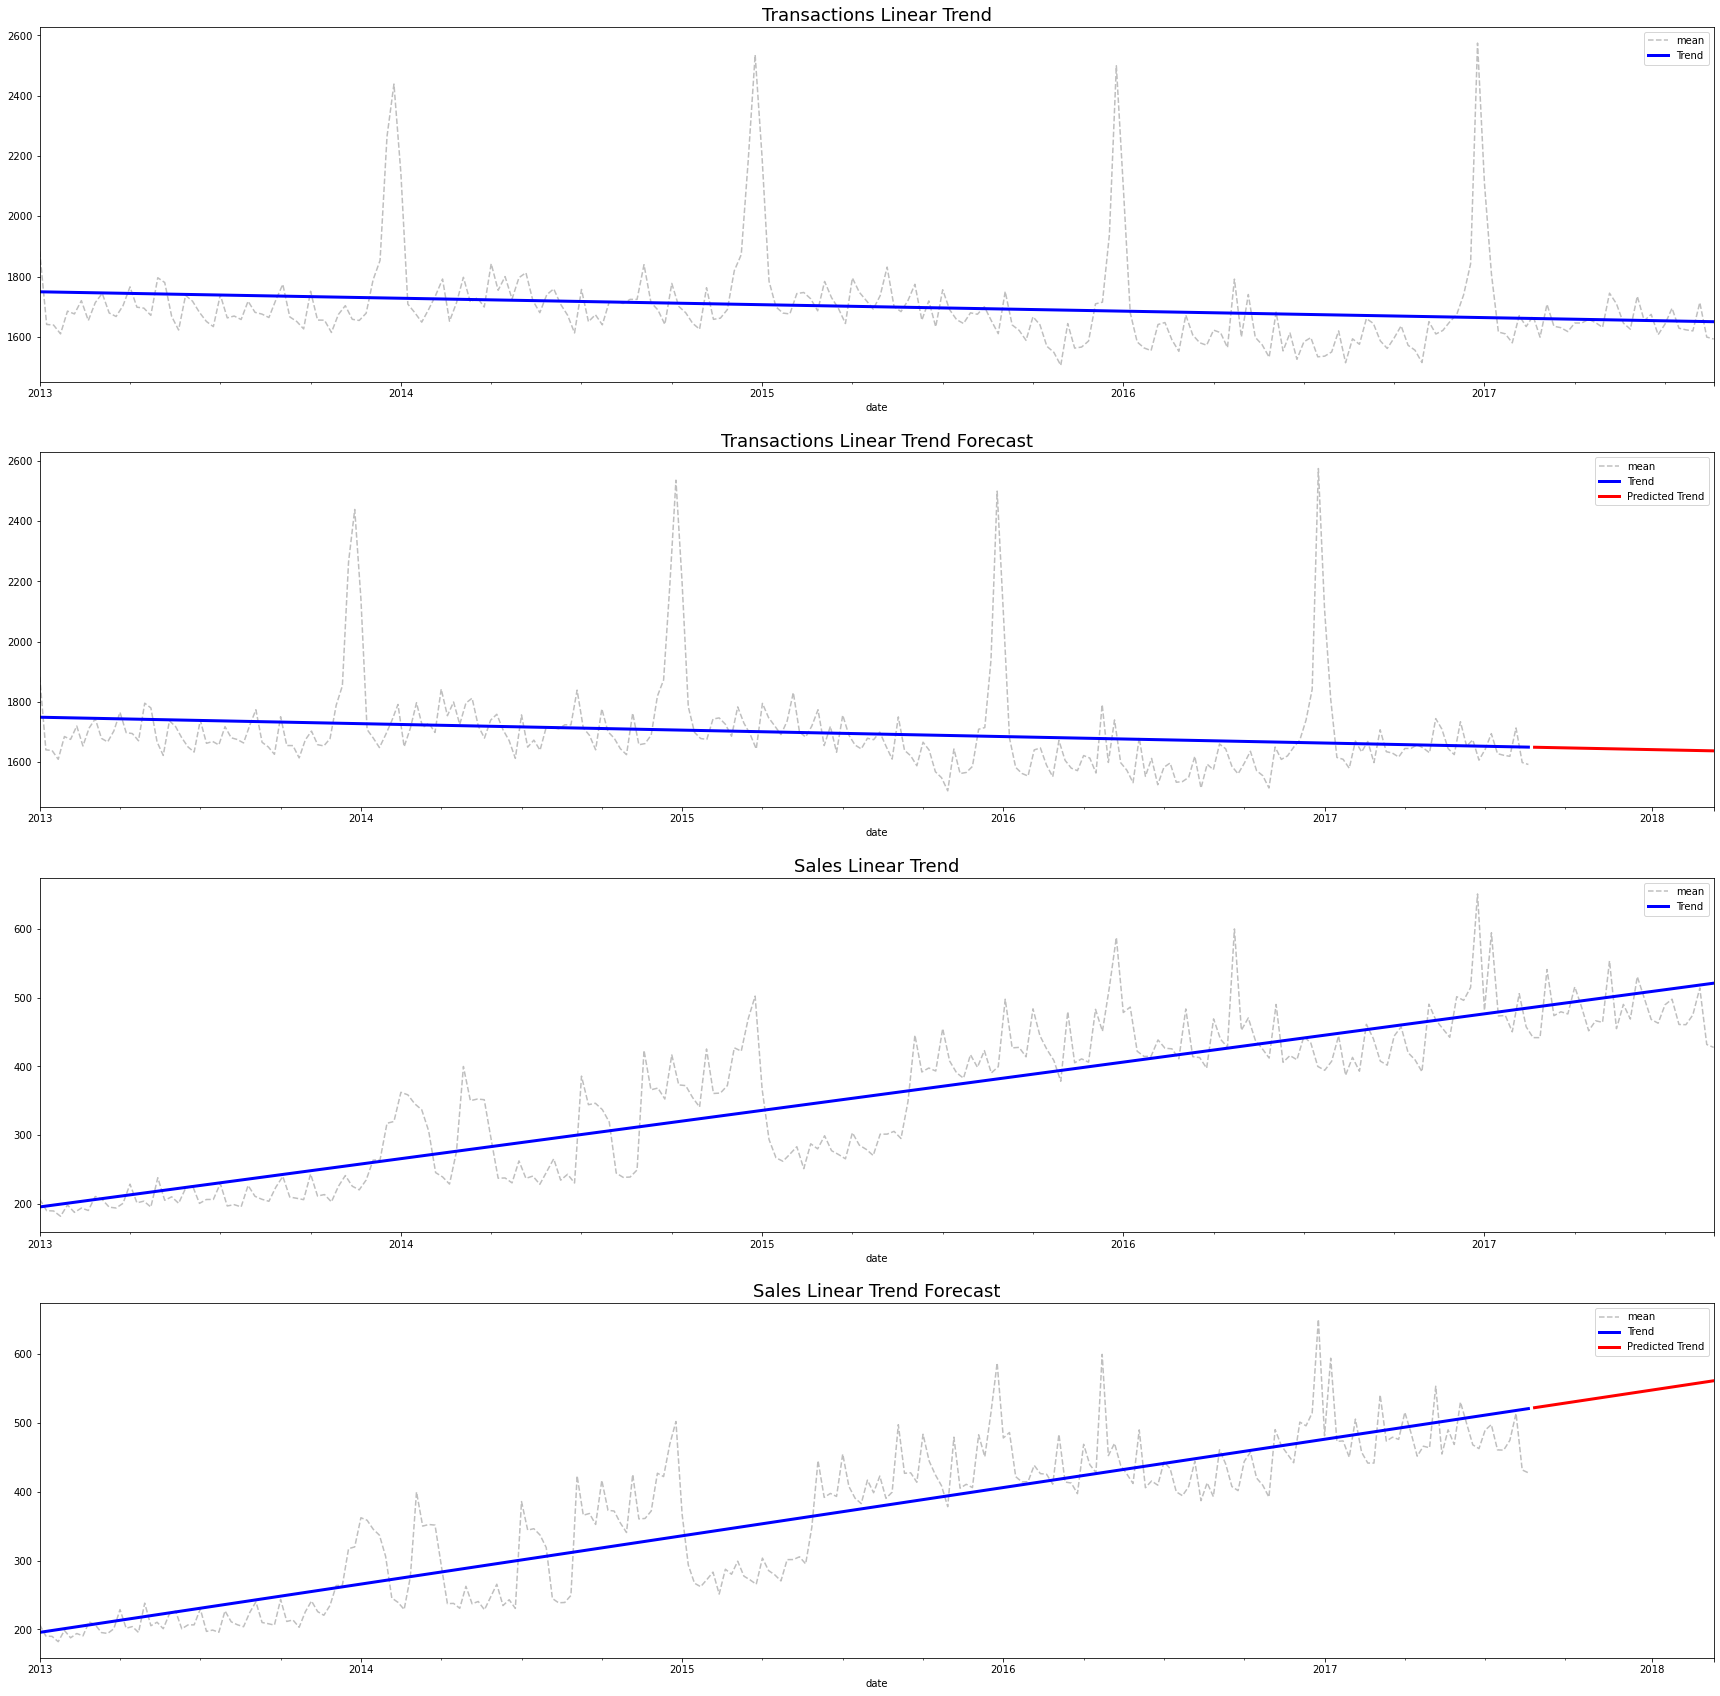

In [12]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(30,30))
plot_deterministic_process(transactions, 'date', 'W', 'transactions', 
                           axes[0], "Transactions Linear Trend",  
                           axes[1], "Transactions Linear Trend Forecast")
plot_deterministic_process(train, 'date', 'W', 'sales', 
                           axes[2], "Sales Linear Trend", 
                           axes[3], "Sales Linear Trend Forecast")
plt.show()

Linear regression excels at extrapolating trends, but can't learn interactions. XGBoost excels at learning interactions, but can't extrapolate trends. Here we'll learn how to create "hybrid" forecasters that combine complementary learning algorithms and let the strengths of one make up for the weakness of the other.

In [13]:
store_sales = train.copy()
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean()
    .unstack('family')
    .loc['2017']
)

Firslty, we should create Boosted Hybrid class:

In [14]:
# we'll add fit and predict methods to this minimal class
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None  # store column names from fit method

Also, we need to create fit method:

In [15]:
def fit(self, X_1, X_2, y):
    # train model_1
    self.model_1.fit(X_1, y)

    # make predictions
    y_fit = pd.DataFrame(
        self.model_1.predict(X_1), 
        index=X_1.index, columns=y.columns,
    )

    # compute residuals
    y_resid = y - y_fit
    y_resid = y_resid.stack().squeeze() # wide to long

    # train model_2 on residuals
    self.model_2.fit(X_2, y_resid)

    # save column names for predict method
    self.y_columns = y.columns
    # Save data for question checking
    self.y_fit = y_fit
    self.y_resid = y_resid


# Add method to class
BoostedHybrid.fit = fit

And predict method

In [16]:
def predict(self, X_1, X_2):
    # Predict with model_1
    y_pred = pd.DataFrame(
        self.model_1.predict(X_1), 
        index=X_1.index, columns=self.y_columns,
    )
    y_pred = y_pred.stack().squeeze()  # wide to long

    # Add model_2 predictions to model_1 predictions
    y_pred += self.model_2.predict(X_2)

    return y_pred.unstack()


# Add method to class
BoostedHybrid.predict = predict

Then we set up data for training:

In [18]:
# Target series
y = family_sales.loc[:, 'sales']


# X_1: Features for Linear Regression
dp = DeterministicProcess(index=y.index, order=1)
X_1 = dp.in_sample()


# X_2: Features for XGBoost
X_2 = family_sales.drop('sales', axis=1).stack()  # onpromotion feature

# Label encoding for 'family'
le = LabelEncoder()  # from sklearn.preprocessing
X_2 = X_2.reset_index('family')
X_2['family'] = le.fit_transform(X_2['family'])

# Label encoding for seasonality
X_2["day"] = X_2.index.day  # values are day of the month

In [19]:
# Create model
model = BoostedHybrid(
    model_1=LinearRegression(),
    model_2=XGBRegressor())

model.fit(X_1, X_2, y)

y_pred = model.predict(X_1, X_2)
y_pred = y_pred.clip(0.0)

In [20]:
# Boosted Hybrid
model = BoostedHybrid(
    model_1=Ridge(),
    model_2=KNeighborsRegressor(),
)

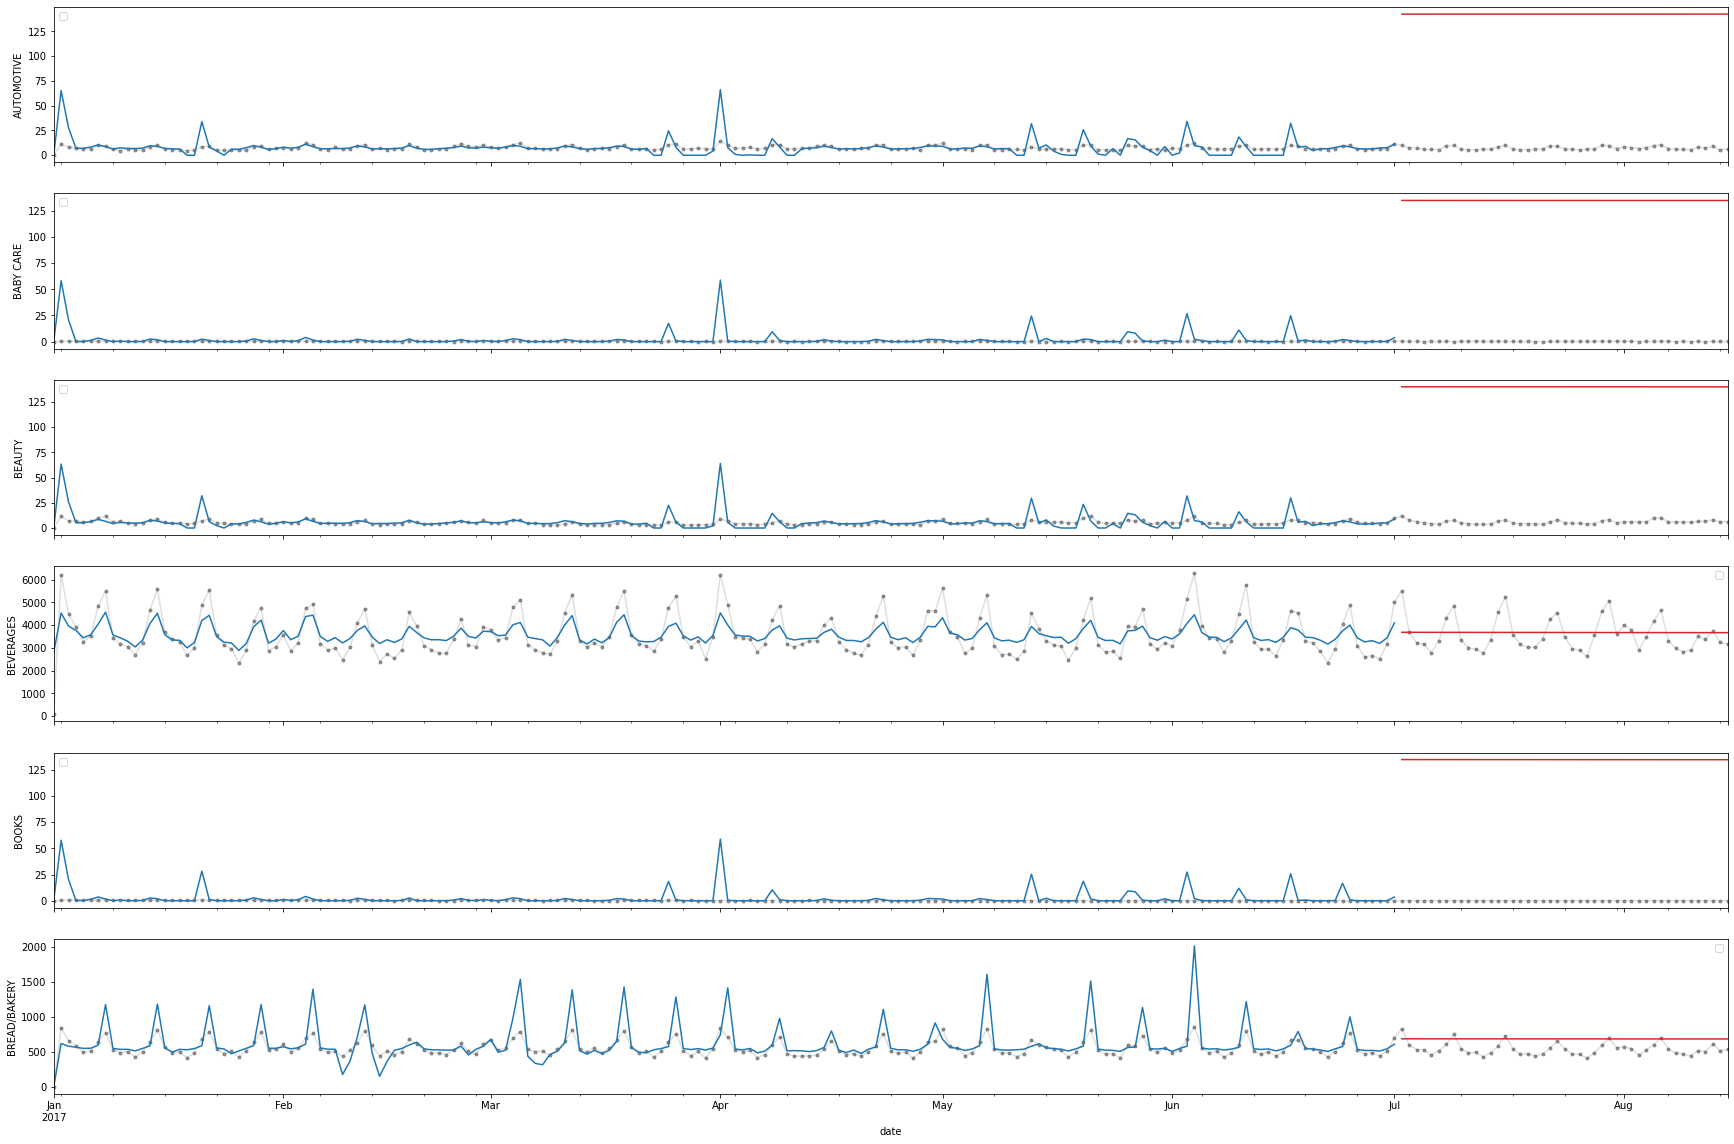

In [21]:
y_train, y_valid = y[:"2017-07-01"], y["2017-07-02":]
X1_train, X1_valid = X_1[: "2017-07-01"], X_1["2017-07-02" :]
X2_train, X2_valid = X_2.loc[:"2017-07-01"], X_2.loc["2017-07-02":]

# Some of the algorithms above do best with certain kinds of
# preprocessing on the features (like standardization), but this is
# just a demo.
model.fit(X1_train, X2_train, y_train)
y_fit = model.predict(X1_train, X2_train).clip(0.0)
y_pred = model.predict(X1_valid, X2_valid).clip(0.0)

families = y.columns[0:6]
axs = y.loc(axis=1)[families].plot(subplots=True, 
                                   sharex=True, 
                                   figsize=(30, 20), 
                                   color="0.75",
                                   style=".-",
                                   markeredgecolor="0.25",
                                   markerfacecolor="0.25",
                                   alpha=0.5)
_ = y_fit.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C0', ax=axs)
_ = y_pred.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C3', ax=axs)
for ax, family in zip(axs, families):
    ax.legend([])
    ax.set_ylabel(family)

Machine Learning Forecasting

In [22]:
# train data
store_sales = train.copy()
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean()
    .unstack('family')
    .loc['2017']
)

In [23]:
# test data
test = test.copy()
test['date'] = test.date.dt.to_period('D')
test = test.set_index(['store_nbr', 'family', 'date']).sort_index()

In [24]:
def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)

In [25]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)

In [26]:
y = family_sales.loc[:, 'sales']

# make 4 lag features
X = make_lags(y, lags=5).dropna()

# make multistep target
y = make_multistep_target(y, steps=16).dropna()

y, X = y.align(X, join='inner', axis=0)

In [27]:
le = LabelEncoder()
X = (X
    .stack('family')  # wide to long
    .reset_index('family')  # convert index to column
    .assign(family=lambda x: le.fit_transform(x.family))  # label encode
)
y = y.stack('family')  # wide to long

display(y) 

y_step_1  y_step_2  y_step_3  y_step_4  \
date       family                                                               
2017-01-06 AUTOMOTIVE                      6.02     10.26      9.39      5.94   
           BABY CARE                       0.28      0.26      0.24      0.44   
           BEAUTY                          6.52     10.04     11.61      5.65   
           BEVERAGES                    3507.28   4848.52   5503.65   3448.20   
           BOOKS                           0.54      0.48      0.72      0.50   
...                                         ...       ...       ...       ...   
2017-07-31 POULTRY                       364.96    403.60    377.31    316.44   
           PREPARED FOODS                 84.70     87.84     88.74     77.17   
           PRODUCE                      2257.14   2609.18   3122.90   1792.22   
           SCHOOL AND OFFICE SUPPLIES     30.11     49.33     57.48     51.91   
           SEAFOOD                        20.49     20.35     20.80     17.12   

                                       y_step_5  y_step_6  y_step_7  y_step_8  \
date       family                                                               
2017-01-06 AUTOMOTIVE                      4.78      6.31      5.39      5.24   
           BABY CARE                       0.24      0.28      0.30      0.30   
           BEAUTY                          6.50      5.28      4.37      4.70   
           BEVERAGES                    3171.74   3046.87   2693.72   3226.04   
           BOOKS                           0.52      0.48      0.39      0.44   
...                                         ...       ...       ...       ...   
2017-07-31 POULTRY                       533.50    416.45    464.60    344.05   
           PREPARED FOODS                 91.89    100.38    102.25     86.63   
           PRODUCE                      2079.32   2418.97   2675.11   2111.13   
           SCHOOL AND OFFICE SUPPLIES     63.22     85.20    100.28     64.41   
           SEAFOOD                        25.55     24.21     23.51     18.42   

                                       y_step_9  y_step_10  y_step_11  \
date       family                                                       
2017-01-06 AUTOMOTIVE                      8.50      10.26       6.41   
           BABY CARE                       0.39       0.43       0.31   
           BEAUTY                          7.78       9.04       5.65   
           BEVERAGES                    4667.30    5580.61    3700.37   
           BOOKS                           0.57       0.56       0.39   
...                                         ...        ...        ...   
2017-07-31 POULTRY                       313.78     305.27     278.82   
           PREPARED FOODS                 77.34      84.80      78.79   
           PRODUCE                      2168.54    2663.08    1670.26   
           SCHOOL AND OFFICE SUPPLIES     59.76      53.74      42.96   
           SEAFOOD                        18.48      18.18      13.28   

                                       y_step_12  y_step_13  y_step_14  \
date       family                                                        
2017-01-06 AUTOMOTIVE                       5.69       5.70       4.78   
           BABY CARE                        0.17       0.22       0.13   
           BEAUTY                           5.35       4.74       3.98   
           BEVERAGES                     3409.80    3263.46    2676.57   
           BOOKS                            0.50       0.41       0.28   
...                                          ...        ...        ...   
2017-07-31 POULTRY                        468.86     354.34     379.80   
           PREPARED FOODS                  96.29      84.69      91.51   
           PRODUCE                       2198.85    2070.15    2331.92   
           SCHOOL AND OFFICE SUPPLIES      65.24      67.48      68.85   
           SEAFOOD                         23.57      19.04      20.70   

                  